In [164]:
from sbcbinaryformat import Streamer, Writer
import numpy as np
import matplotlib.pyplot as plt

from GetEvent import GetEvent

from ana import AcousticT0 
from scipy.signal import firwin, filtfilt
from scipy.optimize import least_squares
import importlib

In [165]:
importlib.reload(AcousticT0)

<module 'ana.AcousticT0' from '/exp/e961/app/users/runze/projects/LAr10Ana/ana/AcousticT0.py'>

In [166]:
TEST_RUN = "/exp/e961/data/SBC-25-daqdata/20250611_1/"
TEST_RUN2 = "/exp/e961/app/users/runze/data/20251121_5/"
TEST_RUN2 = "/exp/e961/app/users/runze/data/20260205_6/"

# TEST_RUN2 = "/exp/e961/data/users/gputnam/SBC-25-daqdata-test/20251103_1/"
# for 1121_5, event 3 is expansion failure
TEST_EVT = 35 # original 0205_6 31

In [167]:
data = GetEvent(TEST_RUN2, TEST_EVT,strictMode=False)
data.keys()

/exp/e961/app/users/runze/projects/LAr10Ana/GetEvent.py:106: UserWarning: No scintillation file present in the run directory. Data will not be available in the returned dictionary.
  warnings.warn("No scintillation file present in the run directory. Data will not be available in the returned dictionary.")


dict_keys(['acoustics', 'scintillation', 'cam', 'event_info', 'plc', 'slow_daq', 'run_info', 'run_control'])

In [168]:
data["cam"].keys()

dict_keys(['loaded', 'c1', 'c2', 'c3'])

In [169]:
data["acoustics"].keys()

dict_keys(['loaded', 'Range', 'DCOffset', 'Waveforms', 'sample_rate'])

In [170]:
data["acoustics"]["Range"]


array([[ 2000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]],
      dtype=int16)

In [171]:
wvfs = data["acoustics"]["Waveforms"]
wvfs.shape

(1, 8, 1300001)

In [172]:
print(data["run_info"].keys())

dict_keys(['loaded', 'run_id', 'run_exit_code', 'num_events', 'run_livetime', 'comment', 'run_start_time', 'run_end_time', 'active_modules', 'pset_mode', 'pset_lo', 'pset_hi', 'source1_ID', 'source1_location', 'rc_ver', 'red_caen_ver', 'niusb_ver', 'sbc_binary_ver'])


In [173]:
print(data["event_info"].keys())
print(data["event_info"]['start_time'])
print(data["event_info"]['end_time'])
print(data["event_info"]['trigger_source'])
print(data["event_info"]['end_time']-data["event_info"]['start_time'])

dict_keys(['loaded', 'run_id', 'event_id', 'ev_exit_code', 'ev_livetime', 'cum_livetime', 'pset_lo', 'pset_hi', 'pset_ramp1', 'pset_ramp_down', 'pset_ramp_up', 'start_time', 'end_time', 'trigger_source'])
[1.77030924e+09]
[1.77030931e+09]
['Pressure']
[69.05415392]


In [174]:
print(data["slow_daq"].keys())
print(data["slow_daq"]['time_ms'])


dict_keys(['loaded', 'time_ms', 'valves', 'TT6415', 'PT1101', 'TT2118', 'TT2119', 'PT2121', 'PT3332', 'PT3333', 'CYL3334_FCALC', 'LT3335', 'SERVO3321_OUT', 'SERVO3321_IN'])
[  140   150   160 ... 77100 77110 77120]


In [175]:
np.float64([[1e2, 1e3, 1e4, 1e5]]).shape

(1, 4)

In [176]:
# plot the first triggered waveform in each channel
# if channel 7 raw reading is ADC -35/1e4
# if channel 7 raw reading is bits, -35/2**15
# MB.PT1101 := AIn.PT1101 * (-35.0* el3052bits);
wvfs_psi = wvfs*(-35/2**16)


In [177]:
piezo0 = wvfs_psi[0, 7, :]
xlimit = [0, 800]
ylimit = [-22.5,-20]
ylimit = [-20,-18]
# first check if the expansion success
average_window_expansion = 100
start_pressure = np.mean(piezo0[:average_window_expansion])
end_pressure = np.mean(piezo0[600000:600000+average_window_expansion])
if start_pressure-end_pressure<0.5:
    print(True)
else:
    print(False)

True


In [178]:
average_window = 15 # every 100 data, do the average
n_chunked = (len(piezo0) // average_window) * average_window # chunk data
piezo0 = piezo0[:n_chunked]

# time in miliseconds
total_time = len(piezo0)
time_list_ms = [i/1e3 for i in range(0,total_time,1)]
time_list_ms  = np.array(time_list_ms[:n_chunked])

piezo0 = piezo0.reshape(-1, average_window).mean(axis=1)
time_list_ms = time_list_ms.reshape(-1,average_window).mean(axis=1)

time length 86666


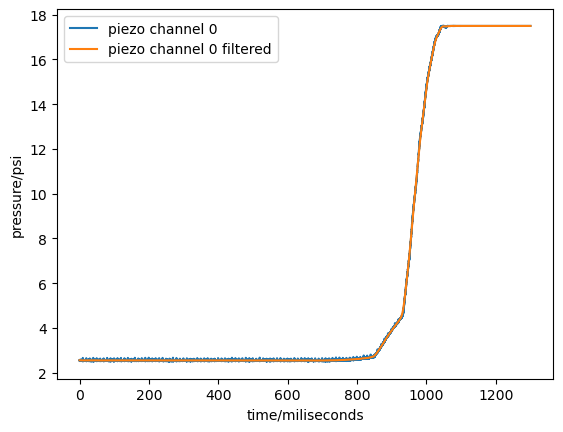

In [179]:
print("time length", len(time_list_ms))
# add low pass filter
# assuming 1 microsecond time resolution 1e6Hz
numtaps = 1000  # filter length (longer = sharper cutoff)
Fs= 1000000/average_window # sampling rate
Fc = 10 # low pass filter in Hz
fir = firwin(numtaps, Fc, window='hamming', fs=Fs)

piezo0_filtered = filtfilt(fir, [1.0], piezo0)
piezoslope0 = (+piezo0_filtered[1:]-piezo0_filtered[:-1])*1e3 # in bar/ms
plt.plot(time_list_ms,piezo0, label="piezo channel 0")
plt.plot(time_list_ms,piezo0_filtered, label="piezo channel 0 filtered")
plt.xlabel("time/miliseconds")
plt.ylabel("pressure/psi")
# plt.xlim(xlimit)
# plt.ylim(ylimit)
plt.legend()

In [180]:
print(piezo0_filtered[20000])

2.5460971758699684


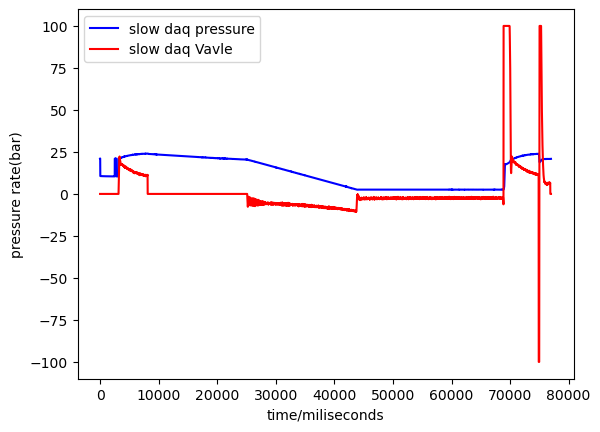

In [181]:
slowdaq_PT = data["slow_daq"]['PT1101']
slowdaq_Valve = data["slow_daq"]['SERVO3321_OUT']
slowdaq_time = [i*10 for i in range(len(slowdaq_PT))]
fig, ax1 = plt.subplots()
startpoint = 10000
endpoint = 10750
# l1 = ax1.plot(slowdaq_time[startpoint:endpoint],slowdaq_PT[startpoint:endpoint], label="slow daq pressure",color="blue")
ax1.plot(slowdaq_time,slowdaq_PT, label="slow daq pressure",color="blue")
ax1.plot(slowdaq_time,slowdaq_Valve, label="slow daq Vavle",color="red")
ax1.set_xlabel("time/miliseconds")
ax1.set_ylabel("pressure rate(bar)")
# ax1.set_xlim(10000, 820)
# ax1.set_ylim(7.5,12)
ax1.legend()

In [182]:
print(data["slow_daq"]['PT1101'][4000])
print(data["slow_daq"]['time_ms'][4000])

6.227112
40140


In [183]:
# find compression time
compress_idx = 0
for i in range(len(data["slow_daq"]['SERVO3321_OUT'])):
    if data["slow_daq"]['SERVO3321_OUT'][i]>75:
        print(i,data["slow_daq"]['SERVO3321_OUT'][i],data["slow_daq"]['time_ms'][i])
        compress_time =data["slow_daq"]['time_ms'][i]
        compress_idx = i
        break

6888 100.0 69020


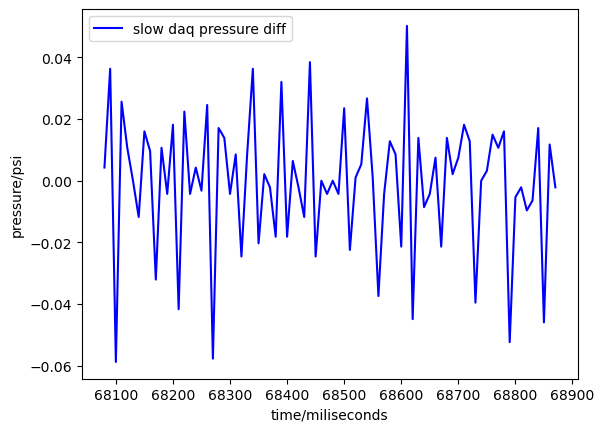

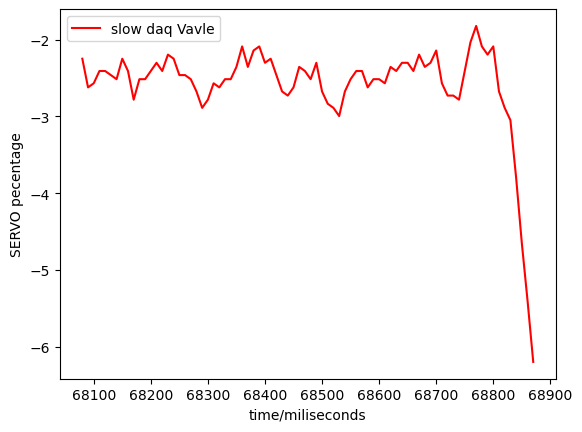

In [184]:
fig, ax1 = plt.subplots()
startpoint = 10000
endpoint = 10750
time_offset = 0
pressure_diff = slowdaq_PT[:-1]-slowdaq_PT[1:]
plt.plot(slowdaq_time[compress_idx-80:compress_idx+time_offset],pressure_diff[compress_idx-80:compress_idx+time_offset], label="slow daq pressure diff",color="blue")
plt.xlabel("time/miliseconds")
plt.ylabel("pressure/psi")
# plt.xlim(xlimit)
# plt.ylim(ylimit)
plt.legend()


fig, ax1 = plt.subplots()

# First axis
l1 = ax1.plot(slowdaq_time[compress_idx-80:compress_idx+time_offset],slowdaq_Valve[compress_idx-80:compress_idx+time_offset], label="slow daq Vavle",color="red")
ax1.set_xlabel("time/miliseconds")
ax1.set_ylabel("SERVO pecentage")
# ax1.tick_params(axis='y', labelcolor="blue")



ax1.legend()


# ax1.plot(slowdaq_time[compress_idx-80:compress_idx],slowdaq_PT[compress_idx-80:compress_idx], label="slow daq pressure",color="blue")
# ax1.plot(slowdaq_time[compress_idx-80:compress_idx],slowdaq_Valve[compress_idx-80:compress_idx], label="slow daq Vavle",color="red")
# ax1.set_xlabel("time/miliseconds")
# ax1.set_ylabel("pressure rate(bar)")
# # ax1.set_xlim(10000, 820)
# # ax1.set_ylim(7.5,12)
# ax1.legend()

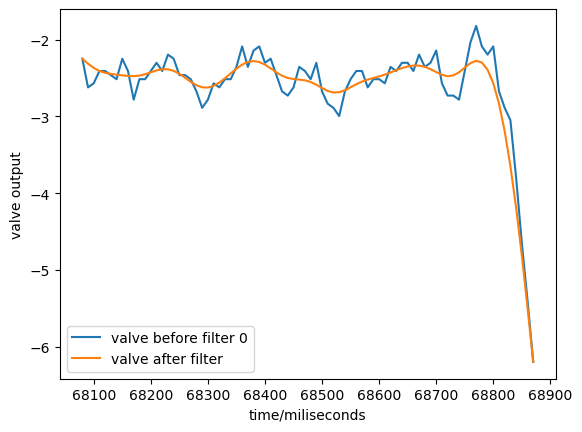

In [185]:
numtaps = 10  # filter length (longer = sharper cutoff)
Fs= 1000 # sampling rate
Fc = 10 # low pass filter in Hz
fir = firwin(numtaps, Fc, window='hamming', fs=Fs)
slowdaq_time_trigger_window = slowdaq_time[compress_idx-80:compress_idx+time_offset]
slowsaq_valve_trigger_window =slowdaq_Valve[compress_idx-80:compress_idx+time_offset]
valve_filtered = filtfilt(fir, [1.0], slowsaq_valve_trigger_window)

plt.plot(slowdaq_time_trigger_window,slowsaq_valve_trigger_window, label="valve before filter 0")
plt.plot(slowdaq_time_trigger_window,valve_filtered, label="valve after filter")
plt.xlabel("time/miliseconds")
plt.ylabel("valve output")
# plt.axvline(x=int(610.8+48300),color="red")
# plt.xlim(xlimit)
# plt.ylim(ylimit)
plt.legend()

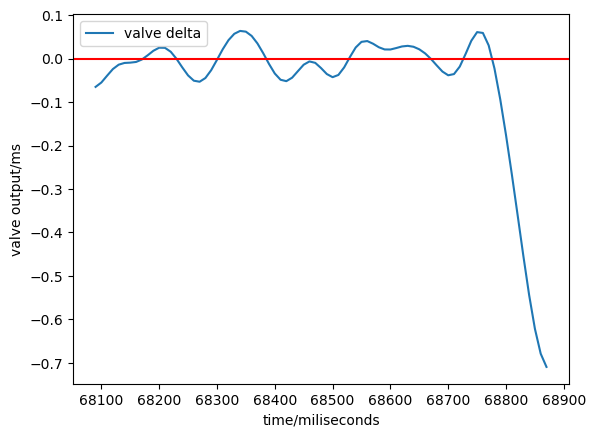

In [186]:
valve_delta = valve_filtered[1:]-valve_filtered[:-1]
plt.plot(slowdaq_time_trigger_window[1:],valve_delta, label="valve delta")
plt.xlabel("time/miliseconds")
plt.ylabel("valve output/ms")
plt.axhline(y=0,color="red")
# plt.axvline(x=int(610.8+48300),color="red")
# plt.xlim(xlimit)
# plt.ylim(ylimit)
plt.legend()

In [187]:
reverse_time = slowdaq_time_trigger_window[::-1]
reverse_valve_delta =valve_delta[::-1]
time_width = reverse_time[-2]-reverse_time[-1]
for i in range(len(reverse_valve_delta)):
    if reverse_valve_delta[i]>0 and reverse_valve_delta[i+1]<0:
        interpolation_time = reverse_time[i] + (0-reverse_valve_delta[i])*(reverse_time[i+1]-reverse_time[i])/(reverse_valve_delta[i+1]-reverse_valve_delta[i])
        print(interpolation_time-reverse_time[-1]+2*time_width)
        break

666.4223169633915


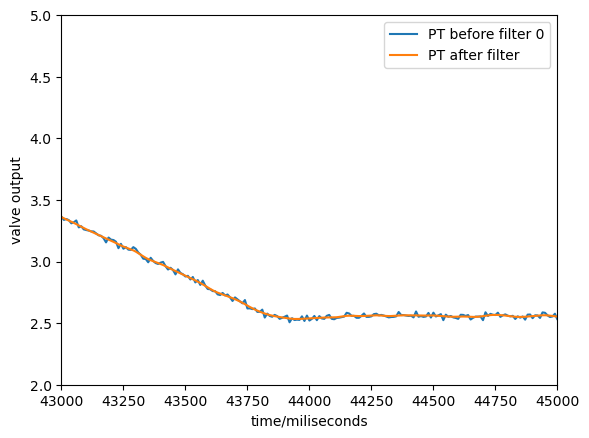

In [202]:
numtaps = 10  # filter length (longer = sharper cutoff)
Fs= 1000 # sampling rate
Fc = 10 # low pass filter in Hz
fir = firwin(numtaps, Fc, window='hamming', fs=Fs)
PT_filtered = filtfilt(fir, [1.0], slowdaq_PT)

plt.plot(slowdaq_time,slowdaq_PT, label="PT before filter 0")
plt.plot(slowdaq_time,PT_filtered, label="PT after filter")
plt.xlabel("time/miliseconds")
plt.ylabel("valve output")
# plt.axvline(x=int(610.8+48300),color="red")
plt.xlim(43000,45000)
plt.ylim(2,5)
plt.legend()

(array([  0.,   0.,   0.,   0.,   2.,   0.,   1.,   1.,   3.,   9.,  22.,
         34., 104., 219., 328., 425., 357., 209.,  88.,  32.,  21.,  12.,
          6.,  15.,   7.,   1.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([-0.025, -0.024, -0.023, -0.022, -0.021, -0.02 , -0.019, -0.018,
        -0.017, -0.016, -0.015, -0.014, -0.013, -0.012, -0.011, -0.01 ,
        -0.009, -0.008, -0.007, -0.006, -0.005, -0.004, -0.003, -0.002,
        -0.001,  0.   ,  0.001,  0.002,  0.003,  0.004,  0.005,  0.006,
         0.007,  0.008,  0.009,  0.01 ,  0.011,  0.012,  0.013,  0.014,
         0.015,  0.016,  0.017,  0.018,  0.019,  0.02 ,  0.021,  0.022,
         0.023,  0.024,  0.025]),
 <BarContainer object of 50 artists>)

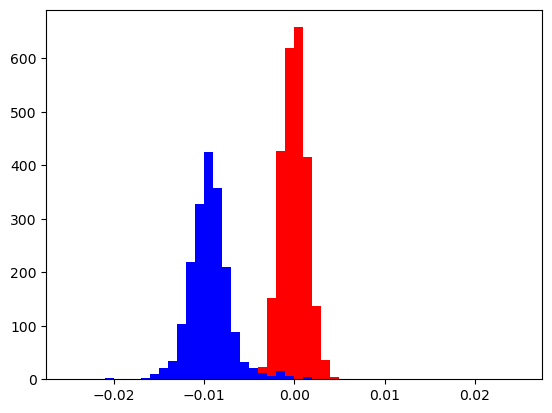

In [212]:
pressure_difference = PT_filtered[1:]-PT_filtered[:-1]
pressure_plain = pressure_difference[4400:6880]
pressure_change = pressure_difference[2500:4400]
bins = 50
plt.hist(pressure_plain, bins =50, range=(-0.025,0.025), color =  "red")
plt.hist(pressure_change, bins =50, range=(-0.025,0.025), color =  "blue")

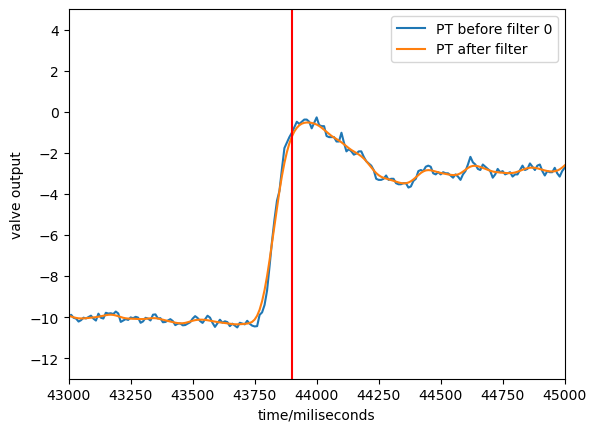

In [237]:
numtaps = 10  # filter length (longer = sharper cutoff)
Fs= 1000 # sampling rate
Fc = 10 # low pass filter in Hz
fir = firwin(numtaps, Fc, window='hamming', fs=Fs)
valve_filtered = filtfilt(fir, [1.0], slowdaq_Valve)

plt.plot(slowdaq_time,slowdaq_Valve, label="PT before filter 0")
plt.plot(slowdaq_time,valve_filtered, label="PT after filter")
plt.xlabel("time/miliseconds")
plt.ylabel("valve output")
plt.axvline(x=int(43900),color="red")
plt.xlim(43000,45000)
plt.ylim(-13,5)
plt.legend()

0.8716906410067109


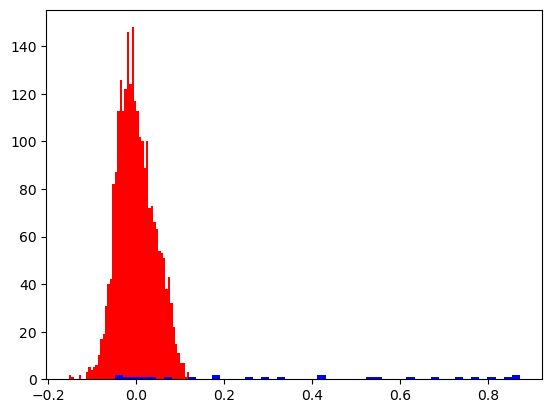

In [224]:
valve_difference = valve_filtered[1:]-valve_filtered[:-1]
valve_plain = valve_difference[4400:6880]
valve_change = valve_difference[4375:4400]
bins = 50
plt.hist(valve_plain, bins =50, color =  "red")
plt.hist(valve_change, bins =50, color =  "blue")
print(max(valve_change))

In [236]:
chunked_valve = valve_difference[:compress_idx-20]
chunked_time = slowdaq_time[:compress_idx-20]
reverse_time = chunked_time[::-1]
reverse_valve_delta =chunked_valve[::-1]
time_width = reverse_time[-2]-reverse_time[-1]
for i in range(len(reverse_valve_delta)):
    if reverse_valve_delta[i]>0.2:
        print(reverse_time[i])
        break

43900


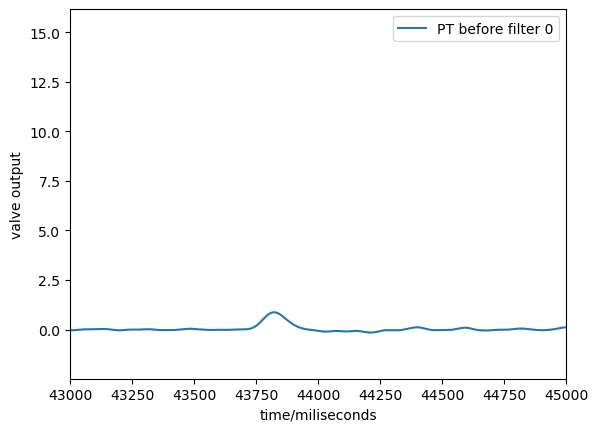

In [234]:
plt.plot(reverse_time,reverse_valve_delta, label="PT before filter 0")
plt.xlabel("time/miliseconds")
plt.ylabel("valve output")
# plt.axvline(x=int(610.8+48300),color="red")
plt.xlim(43000,45000)
# plt.ylim(-13,5)
plt.legend()